In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
df = pd.read_csv("https://raw.githubusercontent.com/tirthajyoti/Machine-Learning-with-Python/refs/heads/master/Datasets/Mall_Customers.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_")
df.sample(5)

,CustomerID,Gender,Age,Annual_Income_(k$),Spending_Score_(1-100)
111,112,Female,19,63,54
16,17,Female,35,21,35
187,188,Male,28,101,68
56,57,Female,51,44,50
185,186,Male,30,99,97


In [55]:
# Simulate some realistic missing values
df.loc[2, 'Annual_Income_(k$)'] = np.nan
df.loc[4, 'Spending_Score_(1-100)'] = np.nan

In [56]:
# Add date and ID columns for more advanced feature engineering
df['CustomerID'] = 1000 + df.index
np.random.seed(0)
df['signup_date'] = pd.to_datetime('2021-01-01') + pd.to_timedelta(np.random.randint(1, 1000, df.shape[0]), unit='D')

In [57]:
df.sample(5)

,CustomerID,Gender,Age,Annual_Income_(k$),Spending_Score_(1-100),signup_date
54,1054,Female,50,43.0,45.0,2022-06-30
6,1006,Female,35,18.0,6.0,2022-12-10
57,1057,Male,69,44.0,46.0,2021-09-03
84,1084,Female,21,54.0,57.0,2023-07-28
65,1065,Male,18,48.0,59.0,2023-03-15


In [58]:
# Time Features
df['signup_month'] = df['signup_date'].dt.month
df['signup_week'] = df['signup_date'].dt.weekday
df['account_age_days'] = (pd.Timestamp.now() - df['signup_date']).dt.days

In [59]:
df.sample(5)

,CustomerID,Gender,Age,Annual_Income_(k$),Spending_Score_(1-100),signup_date,signup_month,signup_week,account_age_days
131,1131,Male,39,71.0,75.0,2023-06-02,6,4,678
19,1019,Female,35,23.0,98.0,2022-12-08,12,3,854
66,1066,Female,43,48.0,50.0,2021-05-10,5,0,1431
197,1197,Male,32,126.0,74.0,2022-06-01,6,2,1044
139,1139,Female,35,74.0,72.0,2022-07-10,7,6,1005


In [60]:
# Derived Feature
df['income_per_age'] = df['Annual_Income_(k$)'] / df['Age']

In [61]:
# Encoding + Scaling Setup
num_cols = ['Age', 'Annual_Income_(k$)', 'Spending_Score_(1-100)', 'account_age_days', 'income_per_age']
cat_cols = ['Gender']

In [62]:
def log_transform(x):
    return np.log1p(x)

In [63]:
num_pipeline = Pipeline([
    ('impute', KNNImputer(n_neighbors=3)),
    ('log', FunctionTransformer(log_transform)),
    ('scale', RobustScaler())
])

In [64]:

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='first'))
])

In [65]:

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [66]:
# Define simple classification target (simulated)
df['target'] = (df['Spending_Score_(1-100)'] > 50).astype(int)
X = df[num_cols + cat_cols]
y = df['target']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [68]:
model_pipeline = Pipeline([
    ('features', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

In [69]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x7a37a3847130>)),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['Age', 'Annual_Income_(k$)',
                                                   'Spending_Score_(1-100)',
                                                   'account_age_days',
                                                   'income_per_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Gender'])])),
                ('clf', RandomForestClassifier(random_state=42))])

In [70]:
y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        17

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [71]:
def plot_feature_importances(pipeline, original_features):
    clf = pipeline.named_steps['clf']
    importances = clf.feature_importances_

    # Manually construct feature names
    num_features = pipeline.named_steps['features'].transformers_[0][2]
    cat_features = pipeline.named_steps['features'].transformers_[1][1] \
        .named_steps['encode'].get_feature_names_out(['Gender'])
    all_features = np.concatenate([num_features, cat_features])

    # Create importance DataFrame
    fi_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
    fi_df.sort_values('Importance', ascending=False, inplace=True)

    # Plot
    sns.barplot(x='Importance', y='Feature', data=fi_df.head(10))
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()

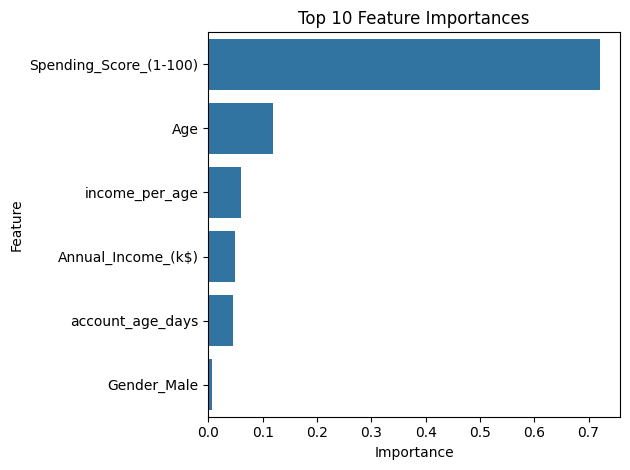

In [72]:
plot_feature_importances(model_pipeline, X.columns)